# ちょっぴりDD-Athenaデモ

今回は説明・デモ全般をSageMaker Notebookで行ってみようと思います！

- Athena 基礎
- Athena Federated Query
- Athena EXPLAIN
- Athena UDF
- Athena ML

## Athena 基礎

Athena ではクエリのためにテーブル定義が必要で、デフォルトでは AWS Glue Data Catalog 上のテーブル定義を使用します。  
AWS Glue Data Catalog にテーブル定義を作成する方法は次の 3 つです。

- Athena DDL
- AWS Glue Catalog API
- AWS Glue Crawler

今回はAthena DDLでテーブルを作成してみましょう。
その前にデータベースをSDKを使って作成します。

データベース作成が完了したら[Athenaコンソール](https://console.aws.amazon.com/athena/home?region=us-east-1#query)で確認してみます。

1. S3にあるデータソースを覗いてみましょう
2. テーブル作成してみる

In [1]:
# 必要なものをimportしておく
import sys
!{sys.executable} -m pip install PyAthena
from pyathena import connect 
import pandas as pd
import sagemaker
import boto3
!{sys.executable} -m pip install graphviz
from graphviz import Source

### 基礎1. S3にあるデータを覗いてみる

In [2]:
import pandas as pd
bucket = 'dddemo-067150986393'
csv_location = 's3://' + bucket + '/data/year=2021/monster.csv'

df = pd.read_csv(csv_location, header=None, names=['id', 'monster_name'])
df.head(10)

,id,monster_name
0,id,monster_name
1,1,スライム
2,2,ドラキー
3,3,スライムベス
4,4,ゴースト
5,5,モーモン
6,6,しましまキャット
7,7,メーダ
8,8,いたずらもぐら
9,9,リリパット


![](./assets/monster.png)

### 基礎2. テーブル作成してみる

S3に保存された先程のmonster.csvファイルを読み込んだテキスト形式のAthenaテーブルを作ってみます。まずはAthenaデータベース作成をします。

In [3]:
s3 = boto3.client('s3')
bucket = 'dddemo-067150986393'
db = 'dddemodb'
wg = 'dddemo'
output_location = 's3://' + bucket + '/athena-dd/'
connection = connect(s3_staging_dir=output_location, region_name='us-east-1', work_group=wg)

# データベース作成
q = '''
CREATE DATABASE {};
'''.format(db)

# pd.read_sql(q, connection)

q = '''
SHOW DATABASES;
'''
pd.read_sql(q, connection)

,database_name
0,dddemodb
1,default
2,mydb
3,qshandson
4,redis
5,sampledb


次にテーブルを作成しましょう。

Athena DDLの記法例

- Athena の DDL は HiveQL 形式で記述
- 標準的なテーブル定義ステートメントの後に、パーティション定義、データ形式、データの場所、圧縮形式などを指定


```
CREATE EXTERNAL TABLE IF NOT EXISTS action_log (
      user_id string,
      action_category string,
      action_detail string
)
  PARTITIONED BY (year int, month int)  -- パーディション
  STORED AS PARQUET -- データ形式
  LOCATION 's3://athena-examples/action-log/’ -- データの場所
  TBLPROPERTIES ('PARQUET.COMPRESS'='SNAPPY'); -- 圧縮形式

```

In [4]:
tablename = 'monster_parquet'
data_location = 's3://' + bucket + '/data/year=2021/' # 今回はパーティションはしない

q = """
CREATE EXTERNAL TABLE IF NOT EXISTS {}.{} (
id string,
monster_name string
)
ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.lazy.LazySimpleSerDe'
WITH SERDEPROPERTIES ('serialization.format' = ',', 'field.delim' = ',')
STORED AS TEXTFILE
LOCATION '{}'
TBLPROPERTIES ('has_encrypted_data'='false',  'skip.header.line.count'='1')
; 
""".format(db, tablename, data_location)

pd.read_sql(q, connection)

# パーディションを更新する場合に必要、今回は不要ですが一応書いてあります
q = """
MSCK REPAIR TABLE {}. {};
""".format(db, tablename)
pd.read_sql(q, connection)

""


In [5]:
# 作成したテーブルに対してクエリを実行してみる
q = """
SELECT * FROM {}.{};
""".format(db, tablename)

print(q)

pd.read_sql(q, connection)


SELECT * FROM dddemodb.monster_parquet;



,id,monster_name
0,1,スライム
1,2,ドラキー
2,3,スライムベス
3,4,ゴースト
4,5,モーモン
...,...,...
374,375,ハロウィンルイーダ
375,376,アバン
376,377,エデンの戦士たち１
377,378,エデンの戦士たち２


#### クエリ結果

実行される各クエリのクエリ結果とメタデータ情報は、指定した S3 バケットに自動的に保存されます。  
この保存自体をオフにすることはできません。  
[Athena コンソール履歴画面](https://console.aws.amazon.com/athena/query-history/home?region=us-east-1)から、クエリ結果ファイルを直接ダウンロードすることが可能です。

In [6]:
# もういらないのでテーブルdropしておく
q = """
DROP TABLE `{}.{}`;
""".format(db, tablename)

pd.read_sql(q, connection)

""


## [Athena フェデレーテッドクエリ](https://github.com/awslabs/aws-athena-query-federation)

様々なデータソースに対して SQL クエリを実行可能です。

AWS Lambda で動作するコネクタを利用して実行する仕組みです。

標準のコネクタとしてさまざまなデータソースが対応済となっています。
- Amazon DynamoDB
- Amazon Redshift
- Apache HBase
- MySQL
- PostgreSQL など

Athena Query Federation SDK を利用して、独自コネクタを実装可能です。


1. lambda作成
2. クエリ実行

![](./assets/federated.png)

### フェデレーテッドクエリ1. lambda作成

フェデレーテッドクエリはjavaで実装されたlambdaアプリケーションを作成する必要があります。  
以下のAthenaDynamoDBConnectorのようなアプリケーションをnotebook上から作成します。

![](./assets/apprepo.png)

今回はjupyter notebookのterminalを使ってインストールを行いますが、  
cloud9を用いた方がスクリプト実行で全て実施できるので導入がスムーズです。  
詳細は[こちら](https://github.com/awslabs/aws-athena-query-federation/tree/master/athena-jdbc)

事前に以下が済んでいることを前提とします。  
mavenをインストールするスクリプトがSageMaker Notebookだと使えないので手動でインストールしました。

- [samのインストール](https://docs.aws.amazon.com/ja_jp/serverless-application-model/latest/developerguide/serverless-sam-cli-install-linux.html) （cloud9の場合は最初から入っています）
- [AWS Serverless Applicationへのアクセス権限追加](https://docs.aws.amazon.com/ja_jp/serverlessrepo/latest/devguide/security_iam_id-based-policy-examples.html)

#### mavenインストール手順（デモではスキップ）

tar.gzを任意のディレクトに配置してください。

```bash
sudo mv apache-maven-3.6.3 /opt/
cd /opt/
sudo ln -s /opt/apache-maven-3.6.3 apache-maven

cp ~/.bash_profile{,.bk}
echo 'MVN_HOME=/opt/apache-maven' >> ~/.bash_profile
echo 'PATH=$MVN_HOME/bin:$PATH:$HOME/.local/bin:$HOME/bin' >> ~/.bash_profile
source ~/.bash_profile

mvn --version

cd -

# フェデレーテッドクエリのLambdaを作成するための諸々が入ったリポジトリをcloneする
git clone https://github.com/awslabs/aws-athena-query-federation.git

# 今回はdynamodbのアプリケーションを作成する
cd aws-athena-query-federation/athena-dynamodb/

mvn clean install -DskipTests=true > /tmp/log
../tools/publish.sh <任意のS3バケット> athena-dynamodb us-east-1
```

#### lambdaの作成（デモでは作成自体はスキップ、既に作成済みのため）

いい感じにS3バケットとそのprefix、lambda関数名を決めます。

![](./assets/appconf.png)
![](./assets/applambda.png)

### フェデレーテッドクエリ2. クエリ実行

それではいよいよdynamoDBテーブルに対してクエリを実行してみましょう。  
該当のdynamoDBテーブル「dddemoテーブル」を[コンソール](https://console.aws.amazon.com/dynamodb/home?region=us-east-1#tables:selected=dddemo;tab=items)から確認してみます。  

それではフェデレーテッドクエリを実行してみます。

In [7]:
dynamo_table = 'dddemo'

q = """
SELECT * FROM "lambda:dynamodd".{}.{};
""".format(db, dynamo_table)

pd.read_sql(q, connection)

,damage,braveid,braveage,braveattack,monsterid,bravesex,bravename,monstername,id,monsterdef
0,7.568956,958.0,31.0,21.0,219.0,男,HashiguchiKouji,メイジキメラ,228,10.688085
1,28.592393,145.0,40.0,785.0,78.0,女,TakeshitaAyane,スライムナイト,1668,69.579645
2,2.423173,974.0,56.0,81.0,194.0,男,NakazawaShigeru,スノードラゴン,1168,67.507086
3,85.063528,422.0,29.0,948.0,7.0,男,IdaNobuyuki,メーダ,1274,41.459886
4,166.389783,123.0,11.0,811.0,186.0,男,YazakiKiyoto,ナウマンボーグ,328,50.147968
...,...,...,...,...,...,...,...,...,...,...
1995,131.972397,639.0,22.0,817.0,350.0,女,SugiuraChikako,おにこぞう,1592,30.363739
1996,26.420846,61.0,35.0,598.0,97.0,男,TakeshitaKazuma,ブラウニー,1218,68.217958
1997,38.191786,913.0,52.0,998.0,115.0,男,OohashiHiroyuki,ひとつめピエロ,1200,57.124458
1998,5.955564,734.0,18.0,84.0,268.0,女,BanHina,キラートーチ,861,88.911394


dddemoテーブルは勇者がモンスターを攻撃する際に登録されます（という想定にします）。  
**アプリケーションさえ作ってしまえばdynamoDBからAthenaでクエリを書けるのでちょっとした分析の際などは便利そうですね！！**  

## Athena EXPLAIN

[Amazon Athena がクエリ実行プランを発表し、調整をサポート](https://aws.amazon.com/jp/about-aws/whats-new/2021/04/amazon-athena-now-presents-query-execution-plans-to-aid-tuning/)  
こちらを試してみる！

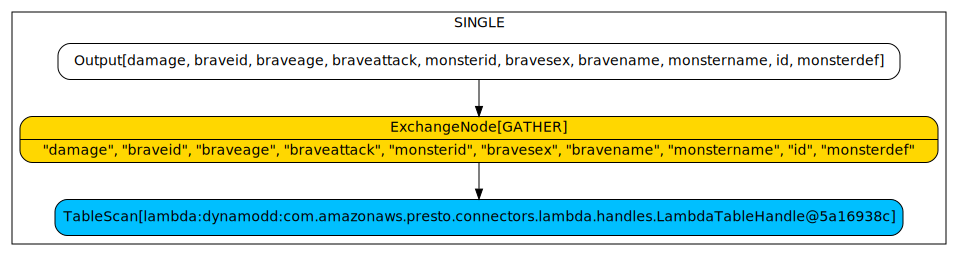

In [8]:
dynamo_table = 'dddemo'

q = """
EXPLAIN (FORMAT GRAPHVIZ) SELECT * FROM "lambda:dynamodd".{}.{};
""".format(db, dynamo_table)

# EXPLAIN結果を受け取る
ex = pd.read_sql(q, connection)

# テキスト形式にする
text = ''
for i in ex['Query Plan']:
    text += str(i)

# 表示する
src = Source(text)
src

## Athena UDF

UDFは基本的にフェデレーテッドクエリと同じ仕組みです！！  

ユーザ独自のスカラー関数を UDF として定義して、SQL クエリで呼び出すことが可能です。  
データの圧縮や解凍、機密データの編集、カスタマイズされた復号の　適用など独自の処理を実行可能です。  
Athena Query Federation SDK を利用して Java で実装し、Lambda 関数として Athena から呼び出されます。  


- 1. lambda作成（フェデレーテッドクエリと同じ流れ）
- 2. クエリ実行

### UDF1. lambda作成

今回は以下のようなredact関数を作成します。  
これは個人情報などをxxで一部マスクするような関数です。  
コードを作成したらフェデレーテッドクエリと同じような形でアプリケーションを作成してLambda関数を作成します。（デモはスキップします）

```java
    public String redact(String input)
    {
        String redactedString = new StringBuilder(input).replace(0, input.length() - 4, new String(new char[input.length() - 4]).replace("\0", "x")).toString(); 
        return redactedString;
    }
```

### UDF2. クエリ実行

最近は勇者の個人情報も守られる傾向にあるのでredact関数は必要ですね・・><  

In [9]:
q = """
-- 参照される Lambda 関数内の Java メソッドに対応した UDF 名を指定します
USING EXTERNAL FUNCTION redact(col1 VARCHAR) RETURNS VARCHAR LAMBDA 'customudf'
SELECT bravename,
         redact(bravename) AS redact_bravename,
         monstername
FROM "lambda:dynamodd".dddemodb.dddemo
""".format(db, dynamo_table)

redacted = pd.read_sql(q, connection)
redacted

,bravename,redact_bravename,monstername
0,HashiguchiKouji,xxxxxxxxxxxouji,メイジキメラ
1,TakeshitaAyane,xxxxxxxxxxyane,スライムナイト
2,NakazawaShigeru,xxxxxxxxxxxgeru,スノードラゴン
3,IdaNobuyuki,xxxxxxxyuki,メーダ
4,YazakiKiyoto,xxxxxxxxyoto,ナウマンボーグ
...,...,...,...
1995,SugiuraChikako,xxxxxxxxxxkako,おにこぞう
1996,TakeshitaKazuma,xxxxxxxxxxxzuma,ブラウニー
1997,OohashiHiroyuki,xxxxxxxxxxxyuki,ひとつめピエロ
1998,BanHina,xxxHina,キラートーチ


## Athena ML

Athena SQL クエリで SageMaker ML モデルを呼び出し、推論を実行可能です。  
異常検出やコホート分析、販売予測などの複雑な作業が SQL クエリで関数を呼び出す感覚で利用できます。  

- 1. 学習&デプロイ
- 2. クエリ実行

### ML1. 学習&デプロイ

事前準備で学習＆推論エンドポイントのデプロイは実施済みです。  
今回、適当なダミーデータを作成したので推論結果は悲惨ですが、Athena MLの機能確認がメインなのでご了承ください。  

```sql
-- ML関数を定義
USING EXTERNAL FUNCTION predict_customer_registration(age INTEGER) 
    RETURNS DOUBLE
    SAGEMAKER 'xgboost-2019-09-20-04-49-29-303' 
SELECT predict_customer_registration(age) AS probability_of_enrolling, customer_id 
     FROM "sampledb"."ml_test_dataset" 
     WHERE predict_customer_registration(age) < 0.5;
```

In [10]:
endpoint = 'sagemaker-xgboost-2021-06-23-05-26-24-351'

q = """
USING EXTERNAL FUNCTION predict(braveid INT, braveage INT, braveattack INT, monsterdef decimal(38, 9)) 
         RETURNS DOUBLE SAGEMAKER '{}'
SELECT braveage as age,
         braveid as id,
         braveattack as attack,
         bravename as brave,
         monstername as monster,
         monsterdef as def,
         damage as damage,
         predict(cast(braveid as INT), cast(braveage as INT), cast(braveattack as INT), monsterdef) as predicted_damage
FROM "lambda:dynamodd".{}.{};
;
""".format(endpoint, db, dynamo_table)

predicted = pd.read_sql(q, connection)

In [11]:
predicted

,age,id,attack,brave,monster,def,damage,predicted_damage
0,31.0,958.0,21.0,HashiguchiKouji,メイジキメラ,10.688085,7.568956,599.778198
1,40.0,145.0,785.0,TakeshitaAyane,スライムナイト,69.579645,28.592393,316.753845
2,56.0,974.0,81.0,NakazawaShigeru,スノードラゴン,67.507086,2.423173,419.834167
3,29.0,422.0,948.0,IdaNobuyuki,メーダ,41.459886,85.063528,240.153107
4,11.0,123.0,811.0,YazakiKiyoto,ナウマンボーグ,50.147968,166.389783,261.213440
...,...,...,...,...,...,...,...,...
1995,22.0,639.0,817.0,SugiuraChikako,おにこぞう,30.363739,131.972397,393.923462
1996,35.0,61.0,598.0,TakeshitaKazuma,ブラウニー,68.217958,26.420846,274.255066
1997,52.0,913.0,998.0,OohashiHiroyuki,ひとつめピエロ,57.124458,38.191786,337.515503
1998,18.0,734.0,84.0,BanHina,キラートーチ,88.911394,5.955564,476.087677


予測精度はクソクソのクソですがクエリで推論できるのは便利ですね！！

## まとめ

- Amazon Athena は、Amazon S3 上のデータに対して、標準 SQL によるインタラクティブクエリを実行して、データ分析を行うことができるサービス
- 少人数のデータサイエンティストが、オンデマンドでSQL を実行したい場合には手軽に分析可能
- Federated Queryを利用することで様々なデータベースへのアドホックなクエリが可能
- UDFを利用することでクエリに対して高度な処理をカスタム実装可能
- EXPLAINができるようになっている
- Athena MLで推論結果の分析にいちいちコード作成不要！

どんどん機能改善しているAthenaをぜひ触ってみてください！（SageMaker Notebookも便利なので是非・・）